##### Flake8 sur Jupyter :

On installe d'abord ceci : "pip install pycodestyle flake8 pycodestyle_magic"

On load la magic suivante

%load_ext pycodestyle_magic

Puis on commence une cellule par %%flake8 pour vérifier les erreurs

# The Social Network

# Librairies 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage.interpolation import shift
from scipy.stats import ks_2samp
from scipy.stats import spearmanr

from tqdm import tqdm

import networkx as nx

from numpy import genfromtxt
from scipy.optimize import fmin
from scipy.optimize import check_grad

## Question 1

### Résultats Théoriques 

Le but est de représenter un réseau social non-orienté par une matrice symètrique,  et de simuler ces matrices sous une loi connue à une constante prêt : 
\begin{equation*}
    p(x|\theta) = \frac{1}{Z(\theta)}\exp^{\theta^{T} S(x)}
\end{equation*}
Où :
- x est la matrice en question,  évoluant dans $R^{n}$,  avec n le nombre d'individus
- S(x) est une statistique sur cette matrice. Nous prendrons le nombre d'arrêtes et le nombre de triangles (trois individus reliés les uns aux autres). Autrement dit : $S(x) = \big[ \sum_{i<j} x_{ij},  \sum_{i<j<k} x_{ij}x_{jk}x_{ki}\big].$ 
- $Z(\theta)$ est inconnue.
Nous pourrons ensuite trouver le paramètre sous-jacent à une observation.
Nous commençons par mettre en oeuvre un algorithme permettant de simuler x sous un $\theta$ donné.

#### Simulation par Gibbs Sampler

Afin de mettre en place cet algorithme,  nous devons trouver la loi de $x{ij}$ sachant $\theta$ et tous les autres coefficients de la matrice x (nous les noterons $x_{-ij}$). On a : $\forall i, j \text{ } \in \text{ } [\![1;n]\!]$

\begin{equation*}
\begin{split}
    \mathbf{P}(X_{ij} = 1 | \theta,  x_{-ij}) & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{-ij} = x_{-ij}} \\
    & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{ij} = 1,  X_{-ij} = x_{-ij}) + \mathbf{P}(X_{ij} = 0,  X_{-ij} = x_{-ij})}\\
    & = \frac{\exp^{\theta^{T} S_{1}(x)}}{\exp^{\theta^{T} S_{1}(x)} + \exp^{\theta^{T} S_{0}(x)}} \\
    & = \frac{1}{1 + \exp^{\theta^{T} (S_{0}(x) - S_{1}(x))}}
\end{split}
\end{equation*}
où $S_{1}(x)$ est la statistique de la matrice x où $x_{ij}$ vaut 1,  et $S_{0}(x)$ la même chose mais pour $x_{ij}$ vallant 0.

### Code

In [2]:
def s_consignes(m):
    '''
    La statistique donnée dans la consigne du projet.
    '''
    g = np.triu(m)

    return np.array([np.sum(g,  axis=(1, 2)),
                     np.sum(np.einsum('ijl, ilk->ijk', g, g)*g, axis=(1,  2))])

In [3]:
def gibbs_etape(x,  position,  u,  theta,  s):
    '''
    Input :

    x est la matrice à l'itération k du gibbs sampler,
    position est la liste [i, j] indiquant la position de la valeur à changer
    u une uniforme dans [0, 1] tirée au préalable
    theta et s sont ceux de la densité

    Output :

    matrice à l'itération k+1 du gibbs sampler
    '''

    m = x.shape[0]  # taille de la matrice

    y = x.copy()  # copies modifiables
    z = x.copy()

    y[position[0], position[1]] = 1
    z[position[0], position[1]] = 0

    s_1 = s(z.reshape(1, m, m))
    s_0 = s(y.reshape(1, m, m))

    proba = 1/(1 + np.exp(theta.dot(np.subtract(s_1, s_0))))

    y[position[0], position[1]] = (u < proba)*1

    y[position[1], position[0]] = y[position[0], position[1]]

    return(y)

In [4]:
def pos(taille_finale, nb_individus):
    """
    Input :

    taille_finale la taille totale que l'on souhaite
    nb_individus le nombre d'individus dans le réseau

    Output :

    Toutes les positions à modifier
    """

    liste_positions = []

    for i in range(nb_individus):
        for j in range(i+1, nb_individus):
            liste_positions += [[i, j]]

    # Copies de la liste
    to_return_1 = liste_positions*(taille_finale//len(liste_positions))

    # Reste de la liste
    to_return_2 = liste_positions[:taille_finale % len(liste_positions)]

    return np.array(to_return_1 + to_return_2)

In [5]:
def gibbs(iterations,  nb_network,  theta,  stat,
          m_0='default', return_statistique=False, esp=1):
    """
    Input :

    iterations : le nombre d'itération dans le gibbs sampling
    nb_network : le nombre d'individus dans le réseau
    theta : un array pour les paramètres de la loi
    stat : une fonction vectorisable sur
    une liste de matrices (statistique exhaustive de notre loi)
    last_sample=True si on veut juste la dernière matrice
    esp : l'espace qud l'on veut entre chaque echantillon retourné

    """
    # Position des éléments que l'on veut
    indices_return = np.cumsum([esp]*(iterations//esp))

    if type(m_0) != np.ndarray:
        # Partir de 0
        m_0 = np.ones((nb_network, nb_network))-np.identity(nb_network)

    r = np.broadcast_to(m_0, (iterations+1, nb_network, nb_network))
    q = r.copy()

    indices = pos(iterations, nb_network)

    u = np.random.uniform(0, 1, iterations)

    for k in tqdm(range(iterations)):
        q[k+1] = gibbs_etape(q[k], indices[k], u[k], theta, stat)

    if return_statistique:
        return stat(q[indices_return])

    else:

        return q[indices_return]

In [6]:
def evolution(vecteur):
    '''
    Evolution moyenne empirique et intervalle de confiance
    asymptotique à 95 pourcent
    '''

    n = len(vecteur)

    x = np.array([i+1 for i in range(n)])

    moyenne_empi = np.cumsum(vecteur)/x

    vect_broad = np.broadcast_to(vecteur, (n, n))
    moy_broad = np.broadcast_to(moyenne_empi, (n, n))

    stdv_empi = np.ones((1, n)).dot((np.triu(vect_broad.T-moy_broad))**2)/x
    stdv_empi = np.sqrt(stdv_empi).reshape((n, ))

    ub = moyenne_empi + (stdv_empi*1.96)/(np.sqrt(x))
    lb = moyenne_empi - (stdv_empi*1.96)/(np.sqrt(x))

    plt.figure(figsize=(12, 5))
    plt.title(" Evolution de la moyenne empirique du vecteur avec intervalle de confiance à 95%")
    plt.plot(moyenne_empi,  color='firebrick')
    plt.fill_between(x,  ub,  lb, color='tomato', alpha=.35)

In [7]:
def graph_network(matrice):
    '''
    Permet de tracer un réseau à partir d'une matrice
    '''
    plt.figure(figsize=(12, 8))
    g = nx.DiGraph(matrice)
    nx.draw(g, with_labels=True)

##### Conformement au théorème ergodique, l'estimateur empirique de l'espérance semble converger.

In [8]:
%%time

r = np.triu(np.random.randint(2,size=[16, 16]), 1)

X_0 = r + r.T

X = gibbs(5000,  16,  np.array([0.1, 0.2]),   s_consignes,  m_0 = X_0,  return_statistique=True,  esp=1)

100%|██████████| 5000/5000 [00:03<00:00, 1425.12it/s]


Wall time: 3.8 s


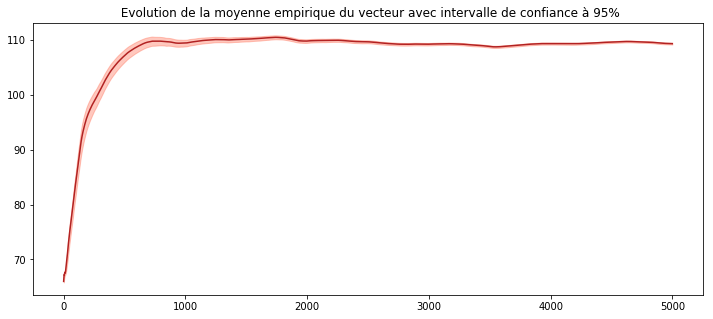

In [9]:
evolution(X[0])  # Nombre d'arrêtes

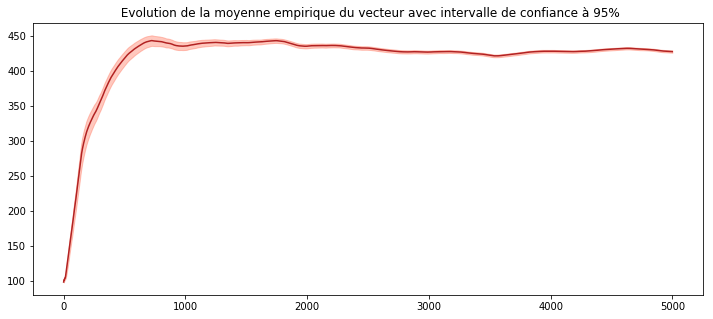

In [10]:
evolution(X[1])  # Nombre de triangles

#### Trouver à quelle itération on a une simulation qui nous convient 

On propose deux méthodes : 

    -Regarder à quelle moment se stabilisent les composantes de la statistique S
    -Commencer l'algorithme de Gibbs Sampling avec différentes valeurs de départ et faire un test d'homogénéité avec Kolmogorov-Smirnov pour voir à quel moment les deux suites ont la meme loi.

In [11]:
def plot_stabilite_stat(vecteur, nb_shift=10):

    '''
    Permet de tracer l'évolution de la valeur de la statistique et
    de ses différences d'ordre nb_shift sur chacune de ses dimensions.
    '''

    fig,  axs = plt.subplots(nrows=2,  ncols=2)
    axs = axs.flatten()
    fig.subplots_adjust(hspace=0.5,  wspace=0.1)
    fig.set_size_inches(18.5,  7)

    # Differentes couleurs pour les plots
    colors = ['darkorange', 'darkmagenta']

    for i in range(2):

        axs[2*i].set_title("Evolution de la composante "+str(i+1)+' de la statistique S')
        axs[2*i].plot(vecteur[i], color=colors[i % 2])

        svecteur = shift(vecteur[i],  nb_shift,  cval=0)
        axs[2*i+1].set_title('''Evolution des différences d'ordre'''+str(nb_shift)
        +' de la composante '+str(i+1)+' de la statistique S')
        axs[2*i+1].plot(vecteur[i]-svecteur, color=colors[i % 2])

In [12]:
# On choisit de faire tourner I itérations sur
# Gibbs pour générer des réseaux de nb_nods personnes

I = 1000
nb_nods = 16

In [13]:
%%time

# Matrice de départ aléatoire
r = np.triu(np.random.randint(2,
                              size=[nb_nods, nb_nods]), 1)

P_random = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                 s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|██████████| 1000/1000 [00:00<00:00, 2319.31it/s]


Wall time: 486 ms


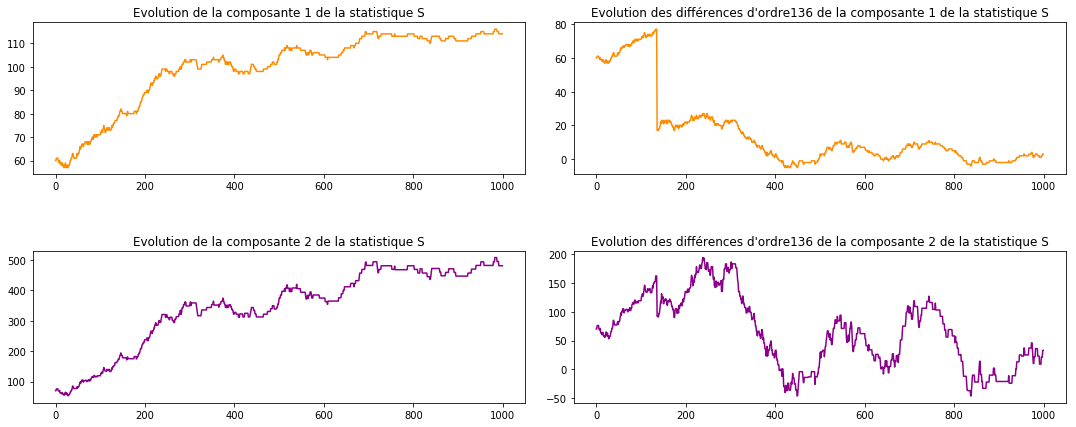

In [14]:
plot_stabilite_stat(P_random, nb_shift=nb_nods*(nb_nods+1)//2)

# 400 itérations semble raissonable avec matrice départ aléatoire

In [15]:
%%time

# Matrice de départ avec des 1 (sauf diagonale nulle)
r = np.ones([nb_nods, nb_nods])-np.identity(nb_nods)

P_ones = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
               s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|██████████| 1000/1000 [00:00<00:00, 3404.54it/s]


Wall time: 338 ms


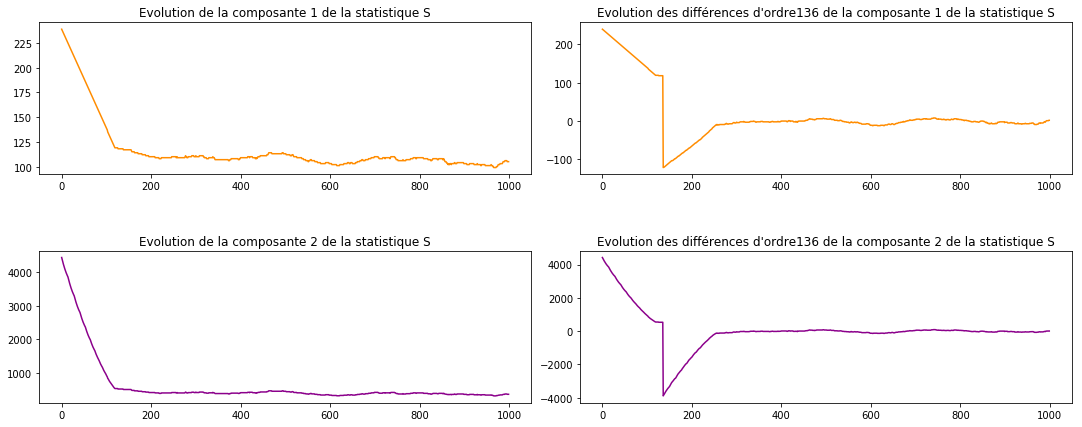

In [16]:
plot_stabilite_stat(P_ones, nb_shift=nb_nods*(nb_nods+1)//2)

In [17]:
%%time
# Matrice de départ avec des 0
r = np.ones([nb_nods, nb_nods])*0 

P_nulles = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|██████████| 1000/1000 [00:00<00:00, 2883.76it/s]


Wall time: 413 ms


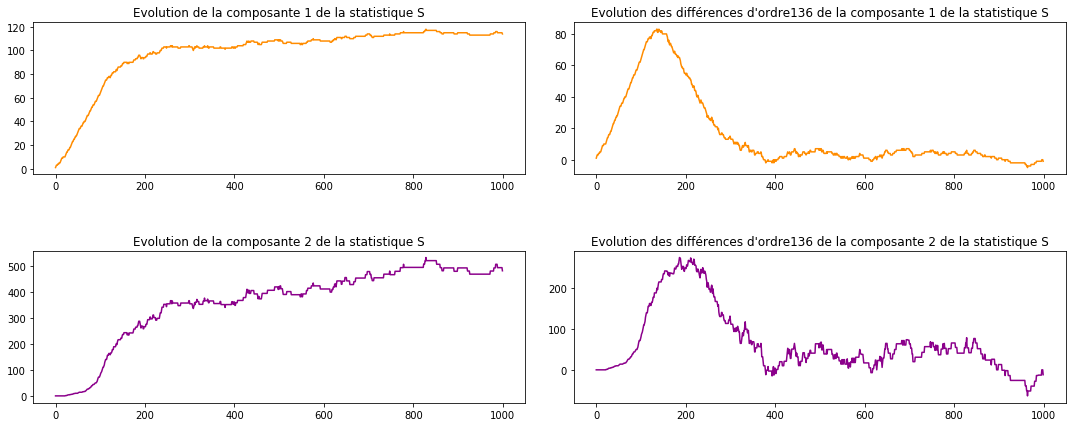

In [18]:
plot_stabilite_stat(P_nulles, nb_shift=nb_nods*(nb_nods+1)//2)

##### Kolmogorov-Smirnov 

Méthode non retenue mais qui permet de prouver que notre algorithme simule bien une même loi.

In [19]:
def plot_pvaleur_ks_continu(vecteur1, vecteur2, size_sample=100):

    plt.figure(figsize=(12, 5))

    if len(vecteur1) != len(vecteur2):
        print('Les deux vecteurs doivent être de même taille !')

    liste_plot = []

    for i in range(len(vecteur1)-size_sample):
        liste_plot += [ks_2samp(vecteur1[i:i+size_sample],
                                vecteur2[i:i+size_sample])[1]]

    plt.title('''Evolution de la p-valeur du test d'homogénéité de Kolmogorov-Smirnov en
    prenant continuement des echantillons de taille '''+str(size_sample)+'''
    le long des vecteurs en input''')

    plt.plot(liste_plot, color='limegreen')

In [20]:
%%time

Run_This_Cell = False  # Peut mettre jusqu'à 10 minutes à tourner

if Run_This_Cell:

    I=100000
    nb_nods=16

    #ecart=(nb_nods*(nb_nods+1)//2)//10
    ecart=200

    r_1 = np.ones([nb_nods, nb_nods])-np.identity(nb_nods) #Matrice de départ avec 1 sauf sur diagonale

    P_1 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r_1+r_1.T, return_statistique=True,  esp=ecart)

    r_2 = np.ones([nb_nods, nb_nods])*0  #Matrice de départ avec 0

    P_2 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r_2+r_2.T, return_statistique=True,  esp=ecart)

    print("La taille de l'écart était de "+str(ecart)+" et la taille de l'échantillon est "+str(len(P_1[0])))

    plot_pvaleur_ks_continu(P_1[0], P_2[0], size_sample=100)

Wall time: 0 ns


On regarde à quel moment la p-valeur dépasse 0.1 et on multipli ce moment par l'écart chosit pour retrouver à quelle itération les variables suivent la même loi

Nota Bene : La continuité vient du fait que les paquets de variables aléatoires ne sont modifié que d'une valeure étape par étape 

Avec une procédure analogue on peut vérfier que nos échantillons font bien des variables qui suivent une même loi

In [21]:
def plot_pvaleur_ks_exclusif(vecteur1, vecteur2, size_sample=100):

    plt.figure(figsize=(12, 5))

    if len(vecteur1) != len(vecteur2):
        print('Les deux vecteurs doivent être de même taille !')
        return False

    liste_plot = []

    for i in range(len(vecteur1)//size_sample):
        to_test_1 = vecteur1[i*size_sample:(i+1)*size_sample]
        to_test_2 = vecteur2[i*size_sample:(i+1)*size_sample]
        liste_plot += [ks_2samp(to_test_1, to_test_2)[1]]

    plt.title('''Evolution de la p-valeur du test d'homogénéité de Kolmogorov-Smirnov en
    prenant des echantillons disjoins de taille '''+str(size_sample)+'''
    le long des vecteurs en input''')

    plt.plot(liste_plot, color='darkcyan')

In [22]:
%%time

Run_This_Cell = False  # Peut mettre jusqu'à 10 minutes à tourner

if Run_This_Cell:

    I = 1000000
    nb_nods = 16

    ecart = (nb_nods*(nb_nods+1)//2)

# Matrice de départ avec 1 sauf sur diagonale
    r_1 = np.ones([nb_nods, nb_nods])-np.identity(nb_nods)

    P_1 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                s_consignes,  m_0=r_1+r_1.T,
                return_statistique=True,  esp=ecart)

# Matrice de départ avec 0
    r_2 = np.ones([nb_nods, nb_nods])*0

    P_2 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                s_consignes,  m_0=r_2+r_2.T,
                return_statistique=True,  esp=ecart)

    print("La taille de l'écart était de "+str(ecart))
    print(" et la taille de l'échantillon est "+str(len(P_1[0])))

    plot_pvaleur_KS_exclusif(P_1[0], P_2[0], size_sample=100)

Wall time: 0 ns


#### A quel moment nos echantillons sont-ils suffisament "indépendants" ?

In [23]:
def plot_pvaleur_spearman(vect, effectif=100,  echantillons_distincts=True):

    plt.figure(figsize=(12, 8))

    liste_plot = []

    premier_index_test = True

    if echantillons_distincts:
        for n in range(len(vect)//effectif):

            p_value = spearmanr(vect[:effectif],
                                vect[effectif*n+1:effectif*(n+1)+1])[1]
            liste_plot += [p_value]

            if premier_index_test and p_value > 0.1:
                print("On ne rejette pas le test en "+str(n)+" .")
                print('''0n multiplie ce nombre à l'écart choisit dans le Gibbs Sample
                pour savoir au bout de combient
                d'itération on est indépendant.''')
                premier_index_test = False

    else:
        for n in range(len(vect)-effectif):

            p_value = spearmanr(vect[0:effectif], vect[n:effectif+n])[1]
            liste_plot += [p_value]

            if premier_index_test and p_value > 0.1:
                print("On ne rejette pas le test en "+str(n)+" .")
                print('''On multiplie ce nombre à l'écart choisit dans le Gibbs Sample
pour savoir au bout de combient d'itération on est indépendant.''')
                premier_index_test = False

    plt.title('''Evolution de la p-valeur du test d'indépendance de Spearman
    en prenant des echantillons de taille '''+str(effectif)+'''
    le long de vecteur''')
    plt.plot(liste_plot, 'o',  color='darkred')

In [24]:
# On veut notre nouvelle matrice d'initialisation

X_0 = np.ones([16, 16])-np.identity(16)

M = gibbs(500,  16,  np.array([0.1, 0.2]),
          s_consignes,  m_0=X_0,  return_statistique=False,  esp=1)

100%|██████████| 500/500 [00:00<00:00, 2046.23it/s]


On peut voir la matrice d'initialisation qui suit bien la loi voulue

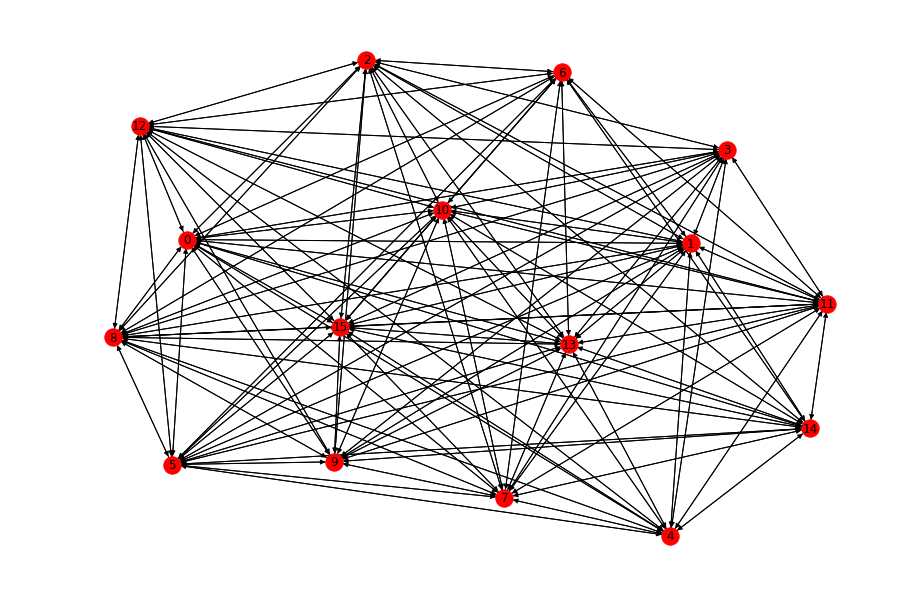

In [25]:
graph_network(M[-1])

In [26]:
X_0 = M[-1]

P = gibbs(10000,  16,  np.array([0.1, 0.2]),   s_consignes,  m_0 = X_0,  return_statistique=True,  esp=30)

100%|██████████| 10000/10000 [00:03<00:00, 3034.20it/s]


On ne rejette pas le test en 5 .
On multiplie ce nombre à l'écart choisit dans le Gibbs Sample
pour savoir au bout de combient d'itération on est indépendant.


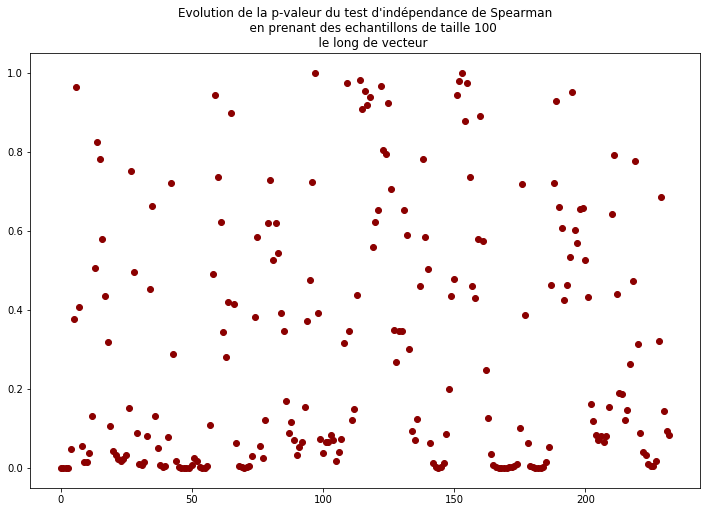

In [27]:
plot_pvaleur_spearman(P[0], echantillons_distincts=False)

# Ici on est indépendant au bout de 8 * 30 = 240 itérations

In [28]:
def plot_stat_spearman(vect, effectif=100,  echantillons_distincts=True):

    plt.figure(figsize=(12, 8))

    liste_plot = []

    premier_index_test = True

    if echantillons_distincts:
        for n in range(len(vect)//effectif):

            stat_spearman = spearmanr(vect[:effectif],
                                vect[effectif*n+1:effectif*(n+1)+1])[0]
            liste_plot += [stat_spearman]

    else:
        for n in range(len(vect)-effectif):

            p_value = spearmanr(vect[0:effectif], vect[n:effectif+n])[0]
            liste_plot += [p_value]

    plt.title('''Evolution de la corrélation de Spearman
    en prenant des echantillons de taille '''+str(effectif)+'''
    le long de vecteur''')
    plt.plot(liste_plot,  color='red')

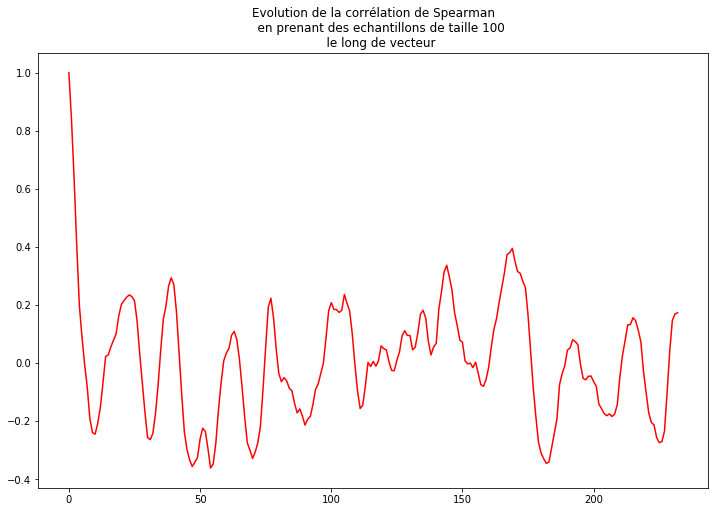

In [29]:
plot_stat_spearman(P[0], echantillons_distincts=False)

Pour aller plus loin : 

Il aurait été interessant de tester l'indépendance entre plusieurs matrices en testant l'indépendance de leurs coefficients ayant la même position. On aurait donc $\frac{(N-1) \times N}{2}$ tests d'indépendance à faire. On pourrait donc utiliser la procédure de Benjamini-Hochberg pour gérer ces tests multiples.

On peut maintenant observer l'évolution de nos estimateurs de Monte Carlo pour la statistique de la consigne

In [30]:
%%time

X_0 = M[-1]

X = gibbs(30000,  16,  np.array([0.1, 0.2]),   s_consignes,  m_0 = X_0,  return_statistique=True,  esp=120)

100%|██████████| 30000/30000 [00:10<00:00, 2728.71it/s]


Wall time: 11.2 s


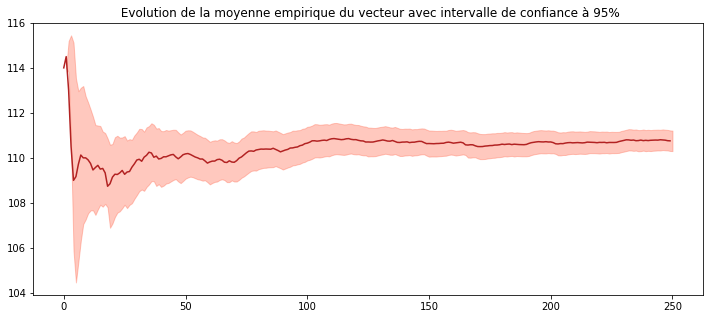

In [31]:
evolution(X[0])  # Le nombre d'arrêtes

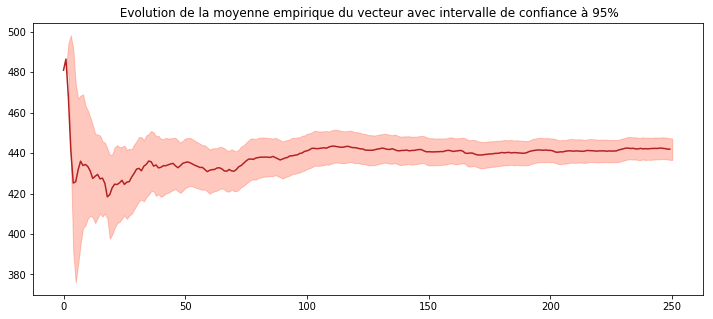

In [32]:
evolution(X[1])  # Le nombre de triangles

## Question 2

Nous commençons par télécharger nos données

In [33]:
X = genfromtxt('famille_florentine.csv', delimiter=',')
X = X[~np.isnan(X)].reshape([16, 16])
x = s_consignes(np.array([X]))

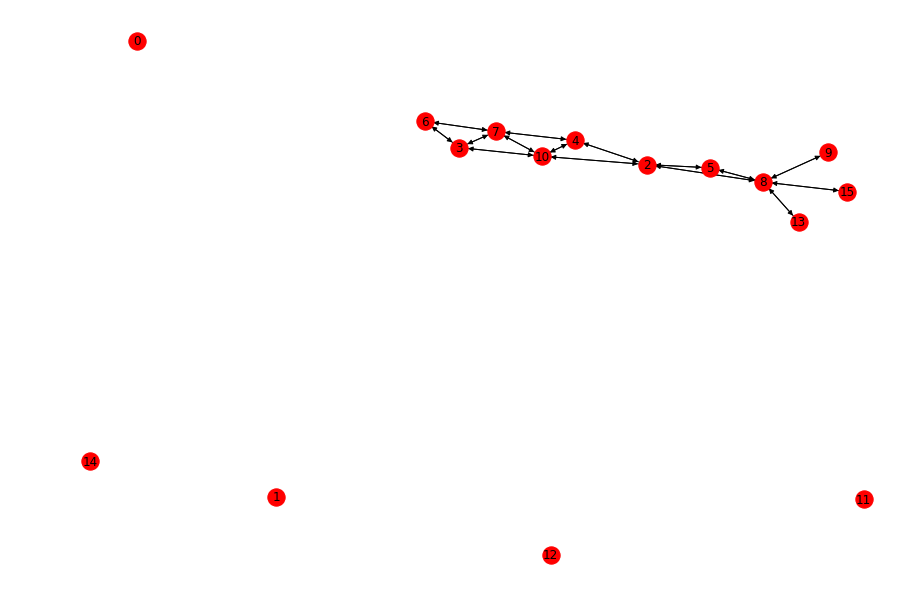

In [34]:
graph_network(X)

### Importance Sampling :
On part de notre équation : 
\begin{equation*}
\begin{split}
    1 & = \mathbb{E}_{\theta_{0}}(\frac{f_{\theta}(X)}{f_{\theta_{0}}(X)}) \\
      & = \mathbb{E}_{\theta_{0}}(\frac{Z(\theta_{0})}{Z(\theta)} \exp^{(\theta - \theta_{0})S(X)})
\end{split}
\end{equation*}
Donc : 
\begin{equation*}
         Z(\theta) = Z(\theta_{0})\mathbb{E}_{\theta_{0}}\exp^{(\theta - \theta_{0})S(X)}
\end{equation*}
Ainsi : 
\begin{equation*}
    \begin{split}
        L(x, \theta) \propto \frac{1}{\mathbb{E}_{\theta_{0}}(\exp^{(\theta - \theta_{0})S(X)})} \exp^{\theta S(x)}
    \end{split}
\end{equation*}
Dès lors, avec $l(x, \cdot)$ la log-vraisemblance du modèle et N le nombre de simulations utilisées pour l'importance sampling :
\begin{equation*}
    \begin{split}
        l(x, \theta) & \propto -\log(\mathbb{E}_{\theta_{0}}(\exp^{(\theta - \theta_{0})S(X)}) + \theta S(x) \\
        & \propto \theta S(x) - \log (\frac{1}{N}\sum_{i = 1}^{N} \exp^{(\theta - \theta_{0})S(X_{i})}) \\
        & \propto \theta S(x) - \log \big(\exp^{(\theta - \theta_{0}) S(X_{m})}\frac{1}{N} \sum_{i=1}^{N} \exp^{(\theta - \theta_{0})*(S(X_{i}) - S(X_{m})}\big) \\
        & \propto \theta S(x) - (\theta - \theta_{0}) S(X_{m}) - \log \big(\frac{1}{N} \sum_{i=1}^{N} \exp^{(\theta - \theta_{0})*(S(X_{i}) - S(X_{m}))} \big)
    \end{split}
\end{equation*}
Avec m tel que :
\begin{equation*}
    \forall i \text{, } (\theta - \theta_{0})S(X_{m}) \geq (\theta - \theta_{0})S(X_{i})
\end{equation*}
Cela nous permet de diminuer l'exponentielle présente dans l'espérance au début du calcul de la log vraisemblance. Cela permet un gain de temps et de précision. Nous réutilisons cette astuce pour calculer le gradient :
\begin{equation*}
    \begin{split}
        \frac{\partial l(x,\theta)}{\partial \theta} & = S(x) - S(X_{m}) - \frac{\frac{1}{N} \sum_{i=1}^{N} (S(X_{i}) - S(X_{m})) \exp^{(\theta - \theta_{0})*(S(X_{i}) - S(X_{m})} }{\frac{1}{N} \sum_{i=1}^{N} \exp^{(\theta - \theta_{0})*(S(X_{i}) - S(X_{m}))}}
    \end{split}
\end{equation*}

In [35]:
def log_vraisemblance(x, theta, u, theta0):
    """
    x est notre observation.

    theta point où on cherche log vraisemblance.

    u vecteur des stats observées sous theta0.

    """

    v = (theta - theta0).dot(u)
    m = np.argmax(v, axis=0) #calcul du maximum, m est le même que dans les calculs ci-dessus
    v2 = (theta - theta0).dot(u[:, m]) 
    w = theta.dot(x) - v2 - np.log(np.mean(np.exp(v - v2)))

    return(w)

In [36]:
def l_prime(x, theta, u, theta0):
    """
    Calcul la dérivée de la lod-vraisemblance, avec :
    
    x la statistique de notre observation.

    u le vecteur des stats calculées auparavant sous theta0.

    Theta le point où on veut calculer la dérivée de la log vraisemblance.

    """

    v = np.subtract(theta, theta0).dot(u)
    m = np.argmax(v, axis=0)

    
    u_subtract = np.subtract(u.T, np.repeat(np.array([u[:, m]]), repeats=u.shape[1], axis=0))
    a = np.exp(np.subtract(theta, theta0).dot(u_subtract.T))

    return(x - u[:, m] - np.mean(u_subtract*np.repeat(np.array([a]).T, repeats=2, axis=1), axis=0)/np.mean(a))

In [37]:
def step_gradient(m_actuel, b_actuel, point,
                  learning_rate, stats_ind_samp, theta_simu_ind_samp):

    # calcul du gradient
    grad = l_prime(point, np.array([m_actuel, b_actuel]),
                   stats_ind_samp, theta_simu_ind_samp)

    m_gradient = grad[0]
    b_gradient = grad[1]

    # nouveau point
    m_nouveau = m_actuel + (learning_rate * m_gradient)
    b_nouveau = b_actuel + (learning_rate * b_gradient)

    return m_nouveau, b_nouveau

In [38]:
def gradient_descent_runner(point, m_dep, b_dep, learning_rate,
                            num_iterations, stats_ind_samp,
                            theta_simu_ind_samp):
    # point de départ
    m = m_dep 
    b = b_dep

    for i in range(num_iterations):
        m, b = step_gradient(m, b, point, learning_rate,
                             stats_ind_samp, theta_simu_ind_samp)

    return np.array([m, b])

In [39]:
def run(x, theta_simu_ind_samp):

    # création des simulations avec notre theta0, ici : theta_simu_ind_samp
    iterations = 200000
    nb_nods = 16
    r = np.triu(np.random.randint(2, size=[nb_nods, nb_nods]), 1)
    stats_ind_samp = gibbs(iterations=iterations,  nb_network=16,
                           theta=theta_simu_ind_samp,  stat=s_consignes,
                           m_0='default', return_statistique=True,
                           esp=120)[:, 3:]

    learning_rate = 0.0001

    initial_b = 0
    initial_m = 0

    num_iterations = 1000

    theta_final = gradient_descent_runner(x, initial_m,
                                          initial_b, learning_rate,
                                          num_iterations, stats_ind_samp,
                                          theta_simu_ind_samp)

    # Effective Sample Size :
    w = np.exp((theta_final - theta_simu_ind_samp).dot(stats_ind_samp))
    ess = np.sum(w)**2/np.sum(w**2)
    print('Effective Sample Size', ess)

    print("Après 1000 iterations on trouve theta valant :", theta_final)
    return(theta_final)

Notre méthode ici a été la suivante : on calcul une première fois notre maximum de vraisemblance à l'aide de la descente de gradient et d'un theta de départ arbitraire. On utilise alors le theta issu de cette maximisation pour re-simuler, et ainsi de suite. Cela prend du temps en raison du nombre de simulations (1000 environ) nécessaires pour avoir une bonne approximation des moyennes utilisées.

In [40]:
print("Début de notre algorithme : ")
theta = run(s_consignes(np.array([X])).reshape([2]), np.array([1, -1]))
print("Deuxième estimation : ")
theta2 = run(s_consignes(np.array([X])).reshape([2]), theta)
print("Troisième estimation : ")
theta3 = run(s_consignes(np.array([X])).reshape([2]), theta2)
print("Quatrième estimation : ")
run(s_consignes(np.array([X])).reshape([2]), theta3)

Début de notre algorithme : 


100%|██████████| 200000/200000 [01:16<00:00, 2617.76it/s]


Effective Sample Size 1.4351451926625851
Après 1000 iterations on trouve theta valant : [-2.21716713 -0.64792978]
Deuxième estimation : 


100%|██████████| 200000/200000 [01:21<00:00, 2447.14it/s]


Effective Sample Size 3.873258173568058
Après 1000 iterations on trouve theta valant : [-0.54393551  0.29933614]
Troisième estimation : 


100%|██████████| 200000/200000 [01:16<00:00, 2629.76it/s]
C:\Users\Hugues\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Effective Sample Size nan
Après 1000 iterations on trouve theta valant : [ -9.09980756 -37.800891  ]
Quatrième estimation : 


100%|██████████| 200000/200000 [01:19<00:00, 2518.47it/s]


Effective Sample Size 24.090328548399217
Après 1000 iterations on trouve theta valant : [1.40040872 0.5       ]


array([1.40040872, 0.5       ])

Nous pouvons observer ici que l'effective sample size ne se réduit pas forcément par cette technique, et qu'il n'y a pas de convergence des thetas issus des itérations successives.

Enfin, nous présentons ici une idée que nous avions eue afin d'approximer au préalable notre theta objectif. Cela aurait permis de faire des simulations sous une loi plus proche de la vraie loi, et donc d'obtenir une meilleure estimation. Notre idée était la suivante : partir d'un theta donné, simuler autour de ce theta, et accepter le point si la distance entre une statistique de matrice simulée sous ce theta est plus proche de la statistique cible qu'avec le point précédent. Cette méthode ne marche pas dans notre cas en raison de l'information donnée par notre statistique, qui peut varier beaucoup d'une simulation à l'autre, et qui ne donne donc pas une bonne idée de la distance entre notre point et le vrai theta.

In [41]:
def distance(a, b):
    return(np.sqrt((a-b).dot(a-b)))

In [42]:
def prem_approx(mat):
    """
    Première approximation empirique du theta correspondant à notre matrice
    """
    stat_mat = s_consignes(mat).reshape([2])

    theta_approx = np.array([0, 0])
    stat_test = np.mean(gibbs(iterations=800,  nb_network=16,
                              theta=theta_approx,  stat=s_consignes,
                              m_0='default', return_statistique=True,
                              esp=400), axis=1)

    while distance(stat_mat, stat_test) >= 20:

        theta_pos = np.diag(np.random.normal(theta_approx, np.eye(2)))
        stat_pos = np.mean(gibbs(iterations=800,  nb_network=16,
                                 theta=theta_approx,  stat=s_consignes,
                                 m_0='default', return_statistique=True,
                                 esp=400), axis=1)

        if (distance(stat_mat, stat_test) - distance(stat_mat, stat_pos)) >= 10:
            theta_approx = theta_pos.copy()
            stat_test = stat_pos.copy()

    return(theta_approx)